# Cosmological differential equations

In [20]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rc

import itertools
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

#from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

### Description

INPUT:

1.- scale factor (sf) $a$

2.- matter density today $\Omega_{m,0}$

3.- Hubble constant today $H_0$

OUTPUT: 

1.- matter density at sf $a$: $\Omega_{m}(a)$

2.- radiation density at sf $a$: $\Omega_{r}(a)$

3.- vacuum density at sf $a$: $\Omega_{\Lambda}(a)$

4.- hubble parameter at sf $a$: $H(a)$


### Training data

$a\in \left[ e^{-12},1\right]$

$\Omega_{m,0} \in \left[ 0.1, 0.4\right]$. By fixing $\Omega_{r,0} = 10^{-4}$,$\Omega_{k,0} = 0$, then $\Omega_{\Lambda,0}$ is automatically determined by $\Sigma_i\Omega_i=1$

$H_0 \in \left[ 65,80\right]$

We will consider all possible combinations (cartesian product)

In [18]:
a = np.linspace(np.exp(-12),1,40)
M0 = np.linspace(0.1,0.4,40)
H0 = np.linspace(65,80,40)

dades = np.array([a, M0, H0]).T #three colums, N rows




R0 = 1e-4
K0 = 0
L0 = 1 - R0 - M0 - K0

list_input = [
    a, #0
    M0, #1
    H0] #2  

6.14421235332821e-06


### Labelling

$H^2(a) = H_0^2\,\left(\Omega_{r,0}\,a^{-4} + \Omega_{m,0}\,a^{-3} + \Omega_{\Lambda,0}\right)$

$\Omega_m(a) = \frac{H_0^2\,\Omega_{m,0}}{a^3\,H^2}$

$\Omega_r(a) = \frac{H_0^2\,\Omega_{r,0}}{a^4\,H^2}$

$\Omega_\Lambda(a) = \frac{H_0^2\,\Omega_{\Lambda,0}}{H^2}$

In [3]:
combinations = np.array(list(itertools.product(*list_input)))
print(combinations.shape)
random.shuffle(combinations)

H = np.zeros(combinations.shape[0])
M = np.zeros(combinations.shape[0])
R = np.zeros(combinations.shape[0])
L = np.zeros(combinations.shape[0])

for p in range(0,combinations.shape[0]):
        H[p] = combinations[p,2]*np.sqrt(R0*combinations[p,0]**(-4) + combinations[p,1]*combinations[p,0]**(-3)+1-combinations[p,1]-R0) 
        M[p] = combinations[p,2]**2*combinations[p,1]*H[p]**(-2)*combinations[p,0]**(-3)
        R[p] = combinations[p,2]**2*R0*H[p]**(-2)*combinations[p,0]**(-4)
        L[p] = combinations[p,2]**2*(1-R0-combinations[p,1])*H[p]**(-2)

print(H.shape)
print(M.shape)
output = np.array([H,M,R,L]).T
print(output.shape)

(64000, 3)
(64000,)
(64000,)
(64000, 4)


### Separating training from validation and test

In [4]:
X_train, X_test, y_train, y_test = train_test_split(combinations, output, test_size = 0.2, random_state = 1234)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(51200, 3)
(12800, 3)
(51200, 4)
(12800, 4)


In [5]:
print(X_train[430,2])
print(y_train[430,3])

75.76923076923077
1.2746732946550901e-17


In [6]:
X_train[:,0] = X_train[:,0] / np.max(a)
X_train[:,1] = X_train[:,1] / np.max(M0)
X_train[:,2] = X_train[:,2] / np.max(H0)
y_train[:,0] = y_train[:,0] / np.max(H)
y_train[:,1] = y_train[:,1] / np.max(M)
y_train[:,2] = y_train[:,2] / np.max(R)
y_train[:,3] = y_train[:,3] / np.max(L)
X_test[:,0] = X_test[:,0] / np.max(a)
X_test[:,1] = X_test[:,1] / np.max(M0)
X_test[:,2] = X_test[:,2] / np.max(H0)
y_test[:,0] = y_test[:,0] / np.max(H)
y_test[:,1] = y_test[:,1] / np.max(M)
y_test[:,2] = y_test[:,2] / np.max(R)
y_test[:,3] = y_test[:,3] / np.max(L)

print(np.max(y_test))

1.0


In [7]:
#sc = StandardScaler()
#X_train = sc.fit_transform(X_train)
#X_test = sc.fit_transform(X_test)
#y_train = sc.fit_transform(y_train)
#y_test = sc.fit_transform(y_test)

#X_train.mean(axis=0), X_train.std(axis=0)
#y_train.mean(axis=0), y_train.std(axis=0)

In [8]:
X_train = torch.from_numpy(X_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

print(y_train.size())

torch.Size([51200, 4])


In [9]:
n_features_i = X_train.shape[1]
n_features_o = y_train.shape[1]
n_samples = X_train.shape[0]

#model = nn.Linear(n_features_i, n_features_o)

class NeuralNet2(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet2,self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.linear2 = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        out = self.linear1(x)
        out = self.relu(out)
        out = self.linear2(out)
        
        return out
    
class NeuralNet4(nn.Module):
    def __init__(self, input_size, h1, h2, h3, h4, num_classes):
        super(NeuralNet4,self).__init__()
        self.linear1 = nn.Linear(input_size, h1)
        self.relu = nn.ReLU()
        self.sig = nn.Sigmoid()
        self.tanh = nn.Tanh()
        self.linear2 = nn.Linear(h1,h2)
        self.linear3 = nn.Linear(h2,h3)
        self.linear4 = nn.Linear(h3,h4)
        self.linear5 = nn.Linear(h4,num_classes)
        
    def forward(self, x):
        out = self.linear1(x)
        out = self.tanh(out)
        out = self.linear2(out)
        out = self.tanh(out)
        out = self.linear3(out)
        out = self.tanh(out)
        out = self.linear4(out)
        out = self.tanh(out)
        out = self.linear5(out)
        
        return out

In [10]:
#model = NeuralNet2(input_size = n_features_i, hidden_size = 100, num_classes = n_features_o)
h1 = 100
h2 = 50
h3 = 25
h4 = 10
model = NeuralNet4(input_size=n_features_i, h1=h1, h2=h2, h3=h3, h4=h4, num_classes=n_features_o)

In [11]:
lr = 0.5
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(),lr=lr)

In [12]:
num_epochs = 10000
for epoch in range(num_epochs):
    #forward and loss
    y_predicted = model(X_train)
    loss = criterion(y_predicted,y_train)
    #backward
    loss.backward()
    #update
    optimizer.step()
    optimizer.zero_grad()
    
    if (epoch+1) % 1000 == 0:
        print(f'epoch: {epoch+1}, loss = {loss.item():.4f}')

epoch: 1000, loss = 0.0385
epoch: 2000, loss = 0.0287
epoch: 3000, loss = 0.0187
epoch: 4000, loss = 0.0158
epoch: 5000, loss = 0.0151
epoch: 6000, loss = 0.0002
epoch: 7000, loss = 0.0003
epoch: 8000, loss = 0.0002
epoch: 9000, loss = 0.0001
epoch: 10000, loss = 0.0001


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


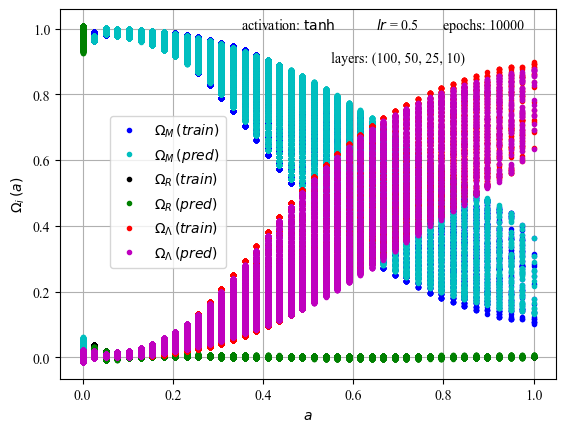

In [41]:
plt.rcParams.update(plt.rcParamsDefault)
#print(plt.style.available)
#plt.style.use('seaborn')
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
#rc('text', usetex=True)
plt.rcParams["font.family"] = "Times New Roman"

predicted = model(X_train).detach().numpy() #requires_grad=false
plt.plot(X_train.detach().numpy()[:,0]*np.max(a),y_train.detach().numpy()[:,1]*np.max(M),'b.', label = '$\Omega_M \,(train) $')
plt.plot(X_train.detach().numpy()[:,0]*np.max(a),predicted[:,1]*np.max(M),'c.',label = '$\Omega_M \,(pred) $')
plt.plot(X_train.detach().numpy()[:,0]*np.max(a),y_train.detach().numpy()[:,2]*np.max(R),'k.',label = '$\Omega_R \,(train) $')
plt.plot(X_train.detach().numpy()[:,0]*np.max(a),predicted[:,2]*np.max(R),'g.',label = '$\Omega_R \,(pred) $')
plt.plot(X_train.detach().numpy()[:,0]*np.max(a),y_train.detach().numpy()[:,3]*np.max(L),'r.',label = '$\Omega_\Lambda \,(train) $')
plt.plot(X_train.detach().numpy()[:,0]*np.max(a),predicted[:,3]*np.max(L),'m.',label = '$\Omega_\Lambda \,(pred) $')
plt.legend(loc = [0.1,0.3])
plt.xlabel('$a$')
plt.text(0.35, 1, r'activation: $\tanh$', fontsize=10)
plt.text(0.55, 0.9, f'layers: {h1,h2,h3,h4}', fontsize=10)
plt.text(0.8, 1, f'epochs: {num_epochs}', fontsize=10)
plt.text(0.65, 1, f'$lr$ = {lr}', fontsize=10)
plt.ylabel('$\Omega_i\,(a)$')
plt.grid()
plt.savefig(f'tanh_lr5_h1{h1}_h2{h2}_h3{h3}_h4{h4}.eps', format='eps')
plt.show()

In [38]:
Xbig = []

X_train_list = list(X_train.detach().numpy()[:,0])
print(len(X_train_list))

for i in range(len(X_train_list)):
    if X_train_list[i]  > 1e-3:
        Xbig[i] = X_train_list[i]
        
    
plt.plot(X_train.detach().numpy()[:,0]*np.max(a),y_train.detach().numpy()[:,0]*np.max(M),'b.', label = '$H \,(train) $')
plt.plot(X_train.detach().numpy()[:,0]*np.max(a),predicted[:,0]*np.max(H),'r.',label = '$H \,(pred) $')
plt.legend(loc = 'best')
plt.xlabel('$a$')
#plt.text(0.4, 1, r'activation: $\tanh$', fontsize=10)
#plt.text(0.55, 0.9, f'layers: {h1,h2,h3,h4}', fontsize=10)
#plt.text(0.7, 1, f'lr = {lr}', fontsize=10)
plt.ylabel('$H(a)$')
plt.grid()

plt.show()

51200


IndexError: list assignment index out of range